In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [4]:
import sys 
import os

parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_path not in sys.path:
    sys.path.insert(1, parent_path)
    
# from src.fake_data import PSP
from src.categorical import pinv, CategoricalEmbedding, PCA, flip_signs, BlackSwanDetector

### Functions for plotting

In [5]:
def rand_jitter(arr):
    stdev = max(0.001, .01*(max(arr)-min(arr)))
    return arr + np.random.randn(len(arr)) * stdev

def scatter_plot(x, y, col, jitter=True):
    
    if jitter:
        x = rand_jitter(x)
        y = rand_jitter(y)
    
    uniq = list(set(col))

    # Set the color map to match the number of species
    hot = plt.get_cmap('hot')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    for i, cat in enumerate(uniq):

        idx = col == cat

        plt.scatter(x[idx], y[idx], 
                    color=scalarMap.to_rgba(i), 
                    label=cat)
        
    # plt.legend(loc='upper left')
    # Put a legend to the right of the current axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [6]:
def generate_tx(anomaly_fields=None):
    
    tx = {
        'method': np.random.choice(['iDeal', 'bank_transfer', 'credit_card'], p=[0.4, 0.3, 0.3]),
        'sender_country': np.random.choice(['NL', 'DE', 'US'], p=[0.8, 0.15, 0.05]),
        'receiver_country': np.random.choice(['NL', 'DE', 'US'], p=[0.8, 0.15, 0.05]),
        'currency': np.random.choice(['EUR', 'USD', 'GBP'], p=[0.33, 0.33, 0.34]), 
        'class': 'normal'
    }
    
    if anomaly_fields:
        
        tx['class'] = 'anomaly'
        
        if 'method' in anomaly_fields:
            tx['method'] = np.random.choice(['iDeal', 'klarna', 'mr_cash'], p=[0.6, 0.2, 0.2])
            
        if 'sender_country' in anomaly_fields:
            tx['sender_country'] = np.random.choice(['GI', 'AF'], p=[0.7, 0.3])
            
        if 'receiver_country' in anomaly_fields:
            tx['receiver_country'] = np.random.choice(['GI', 'AF'], p=[0.5, 0.5])
            
        if 'currency' in anomaly_fields:
            tx['currency'] = np.random.choice(['AFN', 'DZD'], p=[0.5, 0.5])
        
    return tx

fields = ['method', 'sender_country', 'receiver_country', 'currency']

In [7]:
n = 500
p = 0.1

rows = []

for _ in range(n): 
    
    anomaly_fields = []
    while np.random.choice([True, False], p=[p, 1-p]):
        anomaly_fields.append(np.random.choice(fields))
        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df = pd.DataFrame(rows)

In [8]:
df_cat = df.drop(columns='class')
df_dum = pd.get_dummies(df_cat)

In [33]:
sppca = CategoricalEmbedding(drop_colinear_components=False)
bsd = BlackSwanDetector()

df_dum, df_dum_bs = bsd.fit_transform(df_dum)
pcs = sppca.fit_transform(df_dum)

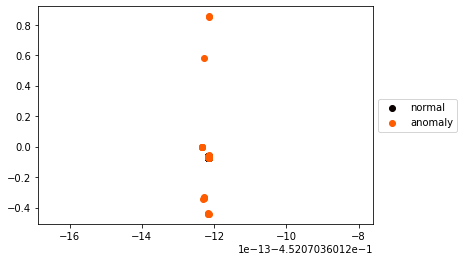

In [36]:
scatter_plot(x = pcs.iloc[:,0], 
             y = pcs.iloc[:,1],
             col = df['class'], 
             jitter=False)

In [10]:
# Convert to numpy array
X = df_dum.values

# Calculate covariance matrix
cov_mat = np.cov(X.T)

# Invert covariance matrix
inv_cov_mat = pinv(cov_mat)

# Eigen decomposition
eig_vals, eig_vecs = np.linalg.eig(inv_cov_mat)

In [14]:
pd.DataFrame(inv_cov_mat, columns=df_dum.columns).style.background_gradient(cmap='viridis')

,method_bank_transfer,method_credit_card,method_iDeal,method_klarna,method_mr_cash,sender_country_AF,sender_country_DE,sender_country_GI,sender_country_NL,sender_country_US,receiver_country_AF,receiver_country_DE,receiver_country_GI,receiver_country_NL,receiver_country_US,currency_AFN,currency_DZD,currency_EUR,currency_GBP,currency_USD
0,-251356670903234.406250,-251356670903237.906250,-251356670903237.562500,-251356670903237.562500,-251356670903236.781250,1918868260057.421631,1918868260058.218018,1918868260058.700439,1918868260058.497803,1918868260058.264160,5378462912514.228516,5378462912513.828125,5378462912513.610352,5378462912514.008789,5378462912514.540039,16448818987826.716797,16448818987826.132812,16448818987825.919922,16448818987826.087891,16448818987825.976562
1,-251356670903238.000000,-251356670903234.531250,-251356670903237.500000,-251356670903237.593750,-251356670903236.625000,1918868260059.267822,1918868260058.375732,1918868260058.547852,1918868260058.255127,1918868260058.000244,5378462912513.231445,5378462912514.024414,5378462912513.774414,5378462912514.057617,5378462912514.207031,16448818987826.193359,16448818987825.509766,16448818987826.183594,16448818987825.980469,16448818987825.822266
2,-251356670903237.843750,-251356670903237.656250,-251356670903234.718750,-251356670903237.562500,-251356670903236.531250,1918868260058.045166,1918868260058.057373,1918868260059.537354,1918868260058.425049,1918868260058.820312,5378462912513.917969,5378462912514.385742,5378462912513.954102,5378462912513.852539,5378462912513.644531,16448818987824.873047,16448818987825.751953,16448818987825.925781,16448818987825.933594,16448818987825.984375
3,-251356670903238.687500,-251356670903238.625000,-251356670903238.406250,-251356670903111.125000,-251356670903237.000000,1918868260058.906250,1918868260059.349121,1918868260060.122070,1918868260058.083984,1918868260059.206787,5378462912514.005859,5378462912509.463867,5378462912513.360352,5378462912512.841797,5378462912513.919922,16448818987826.406250,16448818987826.927734,16448818987824.582031,16448818987826.876953,16448818987825.746094
4,-251356670903236.718750,-251356670903236.500000,-251356670903236.218750,-251356670903235.781250,-251356670903059.062500,1918868260057.340820,1918868260055.809082,1918868260058.240479,1918868260056.945557,1918868260057.583984,5378462912513.919922,5378462912512.206055,5378462912513.915039,5378462912513.398438,5378462912514.237305,16448818987829.593750,16448818987800.914062,16448818987829.085938,16448818987830.150391,16448818987828.888672
5,7570772111305.187500,7570772111307.064453,7570772111305.737305,7570772111305.936523,7570772111304.818359,-518470737960355.250000,-518470737960474.187500,-518470737960477.062500,-518470737960474.000000,-518470737960474.750000,1312457827500.547852,1312457827498.368164,1312457827501.488037,1312457827499.978516,1312457827495.437744,11582217880530.214844,11582217880530.476562,11582217880530.716797,11582217880528.755859,11582217880529.068359
6,7570772111306.619141,7570772111306.808594,7570772111306.384766,7570772111307.014648,7570772111303.922852,-518470737960474.937500,-518470737960459.750000,-518470737960468.937500,-518470737960466.687500,-518470737960467.312500,1312457827503.445801,1312457827501.531738,1312457827502.604492,1312457827501.977783,1312457827502.476318,11582217880529.279297,11582217880528.048828,11582217880529.222656,11582217880529.164062,11582217880529.058594
7,7570772111307.071289,7570772111306.950195,7570772111307.834961,7570772111307.758789,7570772111306.323242,-518470737960477.625000,-518470737960468.687500,-518470737960431.500000,-518470737960468.437500,-518470737960468.812500,1312457827502.945557,1312457827502.039307,1312457827503.049561,1312457827500.875977,1312457827502.147949,11582217880528.634766,11582217880529.605469,11582217880528.056641,11582217880529.250000,11582217880529.154297
8,7570772111306.835938,7570772111306.624023,7570772111306.688477,7570772111305.684570,7570772111304.995117,-518470737960474.81

In [17]:
pd.DataFrame(np.abs(sppca._eig_vecs)).style.background_gradient(cmap='viridis')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.009871,0.109882,0.007267,0.158534,0.300459,0.036467,0.030022,0.053924,0.004147,0.052693,0.005827,0.209674,0.386437,0.567549,0.199306,0.278647,0.074798,0.446605,0.006856,0.006856
1,0.009871,0.108266,0.009884,0.158866,0.297902,0.026139,0.044712,0.057256,0.001456,0.019112,0.031496,0.091728,0.440177,0.447706,0.135603,0.212566,0.537576,0.446605,0.006856,0.006856
2,0.009871,0.109321,0.005182,0.168735,0.289452,0.030473,0.035114,0.070562,0.016259,0.032796,0.053997,0.099592,0.046293,0.111826,0.072253,0.506069,0.610677,0.446605,0.006856,0.006856
3,0.009871,0.484709,0.008450,0.484673,0.562797,0.066684,0.005521,0.043030,0.005194,0.026754,0.003975,0.011449,0.008878,0.008733,0.003489,0.012519,0.002430,0.446605,0.006856,0.006856
4,0.009871,0.812179,0.005885,0.001462,0.325016,0.026396,0.115370,0.138713,0.008375,0.012255,0.012699,0.006905,0.001432,0.000715,0.005062,0.002336,0.000733,0.446605,0.006856,0.006856
5,0.005199,0.003602,0.888120,0.029521,0.016695,0.022691,0.036145,0.016192,0.073664,0.021385,0.034867,0.012887,0.000540,0.018433,0.003561,0.009296,0.002055,0.012161,0.003435,0.003435
6,0.005199,0.005343,0.191379,0.018984,0.011266,0.003546,0.013016,0.016894,0.264779,0.093850,0.583210,0.228810,0.409914,0.335270,0.166899,0.082752,0.047758,0.012161,0.003435,0.003435
7,0.005199,0.000558,0.298563,0.010057,0.003496,0.010041,0.035780,0.005797,0.832648,0.014470,0.111717,0.012749,0.054441,0.025055,0.024875,0.021559,0.004330,0.012161,0.003435,0.003435
8,0.005199,0.000454,0.182198,0.005531,0.007843,0.007726,0.011085,0.003513,0.213346,0.004519,0.291951,0.236817,0.591175,0.462959,0.243662,0.084552,0.025913,0.012161,0.003435,0.003435
9,0.005199,0.000729,0.215980,0.006012,0.001082,0.008470,0.024466,0.001582,0.428187,0.105284,0.728577,0.007869,0.126281,0.084201,0.048327,0.014063,0.024120,0.012161,0.003435,0.003435


In [18]:
pcs.style.background_gradient(cmap='viridis')

In [19]:
pd.DataFrame(np.cov(pcs.T)).style.background_gradient(cmap='viridis')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
1,0.000000,0.006147,-0.000007,-0.000004,-0.000007,0.000007,0.000003,-0.000011,-0.000010,0.000018,-0.000002,0.000013,0.000149,-0.000104,0.000126,0.000047,-0.000025,0.000000,0.000000,0.000000
2,-0.000000,-0.000007,0.009418,0.000016,0.000018,0.000002,-0.000005,-0.000006,0.000044,-0.000012,0.000088,-0.000005,-0.000048,0.000030,-0.000033,0.000026,-0.000011,-0.000000,0.000000,0.000000
3,0.000000,-0.000004,0.000016,0.010421,-0.000034,0.000034,-0.000008,-0.000005,-0.000013,0.000008,0.000031,0.000004,-0.000118,-0.000213,0.000026,-0.000112,0.000195,-0.000000,-0.000000,-0.000000
4,-0.000000,-0.000007,0.000018,-0.000034,0.011772,0.000441,0.000015,-0.000044,-0.000008,0.000007,0.000054,0.000025,-0.000271,-0.000261,-0.000004,0.000030,0.000309,-0.000000,-0.000000,-0.000000
5,-0.000000,0.000007,0.000002,0.000034,0.000441,0.011985,0.000011,0.000011,-0.000000,-0.000042,0.000015,0.000020,0.000090,0.000008,-0.000086,0.000054,-0.000238,0.000000,0.000000,0.000000
6,-0.000000,0.000003,-0.000005,-0.000008,0.000015,0.000011,0.017834,0.000096,-0.000017,-0.000026,-0.000048,-0.000000,-0.000008,-0.000099,0.000034,-0.000281,0.000148,0.000000,-0.000000,-0.000000
7,0.000000,-0.000011,-0.000006,-0.000005,-0.000044,0.000011,0.000096,0.019051,0.000008,-0.000016,0.000007,-0.000036,-0.000018,0.000063,-0.000023,0.000189,0.000072,-0.000000,-0.000000,-0.000000
8,-0.000000,-0.000010,0.000044,-0.000013,-0.000008,-0.000000,-0.000017,0.000008,0.031918,0.000046,0.000126,0.000159,-0.000131,0.000059,0.000056,-0.000121,0.000270,-0.000000,-0.000000,-0.000000
9,-0.000000,0.000018,-0.000012,0.000008,0.000007,-0.000042,-0.000026,-0.000016,0.000046,0.065996,-0.000323,0.001038,0.000171,-0.000315,0.000285,-0.000275,0.001724,-0.000000,-0.000000,-0.000000


In [26]:
sppca = CategoricalEmbedding(drop_colinear_components=True)
bsd = BlackSwanDetector()

df_dum, df_dum_bs = bsd.fit_transform(df_dum)
pcs = sppca.fit_transform(df_dum)

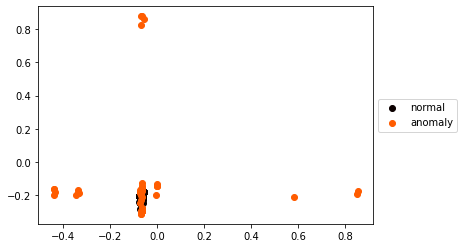

In [31]:
scatter_plot(x = pcs.iloc[:,0], 
             y = pcs.iloc[:,1],
             col = df['class'], 
             jitter=False)

In [ ]:
n = 20

x = np.random.binomial(1, 0.001, size = n)
df = pd.DataFrame({
    'a': np.random.binomial(1, 0.5, size = n),
    'b': np.random.binomial(1, 0.3, size = n),
    'c': np.random.binomial(1, 0.1, size = n) + x,
    'd': np.random.binomial(1, 0.01, size = n) + x,
    'e': np.random.binomial(1, 0.001, size = n)
})

In [ ]:
sppca = CategoricalEmbedding(drop_colinear_components=True)
#bsd = BlackSwanDetector()

#df_dum, df_dum_bs = bsd.fit_transform(df)
pcs = sppca.fit_transform(df)

In [ ]:
scatter_plot(x = pcs.iloc[:,0], 
             y = pcs.iloc[:,1],
             col = df['c'], 
             jitter=True)

In [ ]:
positive_counts = df_dum.apply(lambda x: sum(x))
positive_counts.sort_values()

### Experiment 2: what dimensions are captured without any anomalies?

Hypothesis: the dimensions with the smallest variance --> very unbalanced classes

* method: balanced
* sender_country: unbalanced --> US smallest category
* receiver_country: unbalanced --> US smallest category
* currency: balanced


In [ ]:
n = 500

rows = []

for _ in range(n): 
    
    anomaly_fields = []        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df_clean = pd.DataFrame(rows)

In [ ]:
df_cat_clean = df_clean.drop(columns='class')
df_dum_clean = pd.get_dummies(df_cat_clean)

In [ ]:
sppca_clean = CategoricalEmbedding()
pcs_clean = sppca_clean.fit_transform(df_dum_clean)

In [ ]:
# Calculate components
components = super().transform(X, None)

In [ ]:
# Which components have a variance larger than the threshold
components_mask = np.diag(np.cov(components.T)) > 1e-18

Focus is indeed on the US

In [ ]:
scatter_plot(x = pcs_clean[:,0], 
             y = pcs_clean[:,1], 
             col = df_clean['receiver_country'], jitter=False)

### Experiment 3: what happens when a category is not present in train set?

Hypothesis: if a category is not present in the training set the sspca will not focus on this dimension

In [ ]:
n = 500

rows = []

for _ in range(n): 
    
    anomaly_fields = []        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df_clean = pd.DataFrame(rows)

In [ ]:
df_cat_clean = df_clean.drop(columns='class')
df_dum_clean = pd.get_dummies(df_cat_clean)
df_dum_clean['black_swan'] = 0

In [ ]:
sppca_clean = SparsityPreservingPCA(black_swan_protection=False)
pcs_clean = sppca_clean.fit_transform(df_dum_clean)
pcs_clean.shape

In [ ]:
scatter_plot(x = pcs_clean[:,0], 
             y = pcs_clean[:,1], 
             col = df_dum_clean['black_swan'])

In [ ]:
df_dum_contam = df_dum_clean.copy()
df_dum_contam.loc[0, 'black_swan']=1

In [ ]:
pcs_contam = sppca_clean.transform(df_dum_contam)

The anomaly is indeed not distinguishable in the first pcs. Around PC10 the anomaly becomes visible.

In [ ]:
scatter_plot(x = pcs_contam[:,0], 
             y = pcs_contam[:,1], 
             col = df_dum_contam['black_swan'])

### Experiment 4: remedy for black swan events

Hypothesis: if we append a row with all zeros and a row with all ones to the dummie df, black swan events can be captured

Implemented in SparsityPreservingPCA class --> argument black_swan_protection=True

In [ ]:
n = 500

rows = []

for _ in range(n): 
    
    anomaly_fields = []        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df_clean = pd.DataFrame(rows)

In [ ]:
df_cat_clean = df_clean.drop(columns='class')
df_dum_clean = pd.get_dummies(df_cat_clean)
df_dum_clean['black_swan1'] = 0
df_dum_clean['black_swan2'] = 0

In [ ]:
sppca_clean = SparsityPreservingPCA(black_swan_protection=True)
pcs_clean = sppca_clean.fit_transform(df_dum_clean)

In [ ]:
scatter_plot(x = pcs_clean[:,0], 
             y = pcs_clean[:,1],
             col = df_clean['method'], jitter=False) #df_dum_clean['black_swan1'])

In [ ]:
positive_counts = df_dum_clean.apply(lambda x: sum(x))
positive_counts.sort_values()

In [ ]:
df_dum_contam = df_dum_clean.copy()
df_dum_contam.loc[0, 'black_swan1']=1
df_dum_contam.loc[0, 'black_swan2']=0

In [ ]:
pcs_contam = sppca_clean.transform(df_dum_contam)

The anomaly is now detected in the dimensions, this is the black swan column

In [ ]:
scatter_plot(x = pcs_contam[:,0], 
             y = pcs_contam[:,1], 
             col = df_dum_contam['black_swan1'])

In [ ]:
scatter_plot(x = pcs_clean[:,2], 
             y = pcs_clean[:,1], 
             col = df_clean['receiver_country'])